# <center>Upturn in Churn a Serious Concern </center>

<img src="img/leaky_customers.jpg" width=600 height=600 />

In [1]:
# Data manipulation imports
import pandas as pd
import numpy as np
import scipy.stats as stats

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Custom module imports
import acquire
import prepare

## Acquire Data

In [2]:
# Read telco data into a dataframe
df = acquire.get_telco_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   internet_service_type_id  7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [3]:
df.nunique()

internet_service_type_id       3
payment_type_id                4
contract_type_id               3
customer_id                 7043
gender                         2
senior_citizen                 2
partner                        2
dependents                     2
tenure                        73
phone_service                  2
multiple_lines                 3
online_security                3
online_backup                  3
device_protection              3
tech_support                   3
streaming_tv                   3
streaming_movies               3
paperless_billing              2
monthly_charges             1585
total_charges               6531
churn                          2
contract_type                  3
payment_type                   4
internet_service_type          3
dtype: int64

In [4]:
acquire.describe_with_range(df)

,count,mean,std,min,25%,50%,75%,max,range
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00,2.0
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00,3.0
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00,2.0
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00,1.0
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00,72.0
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75,100.5


### Acquire Takeaways

- Within my Acquire.py script, I wrote an SQL query which pulls the relevant Telco data from the Codeup Database. It then stores it in a locally cached .csv file for quick future access.
- The raw data pulled in contains 7043 rows and 24 columns.
- There are no obvious nulls present and it remains to be seen what data will be usable.
- Upon summary investigation, it's obvious that several columns data types are classified incorrectly.
    - Columns internet_service_type_id, payment_type_id, and contract_type_id are all categorical data and should be stored as objects, not numerical data (int64).
    - The senior_citizen column is also categorical data that I will leave as numerical as it will be encoded later anyway.
    - total_charges contains numerical data that is stored as an object.
    - These will need to be dealt with during the prepare stage.

## Prepare Data

Upon further investigation, I found that internet_service_type_id, payment_type_id, contract_type_id columns are all redundant; the same information is stored in other columns.  I will be dropping these three columns.  

See the cell below for an example

In [5]:
df.internet_service_type.value_counts(), df.internet_service_type_id.value_counts()

(Fiber optic    3096
 DSL            2421
 None           1526
 Name: internet_service_type, dtype: int64,
 2    3096
 1    2421
 3    1526
 Name: internet_service_type_id, dtype: int64)

Additionally, the information in the phone_service column is 100% reproduced with MORE info in the multiple_lines column. As such I will be dropping the phone_service column.

Dealing with total_charges is a bit more tricky as there were blanks used in place of null or zero values. I will convert those to zeros and then change the entire column to a numeric dataframe.

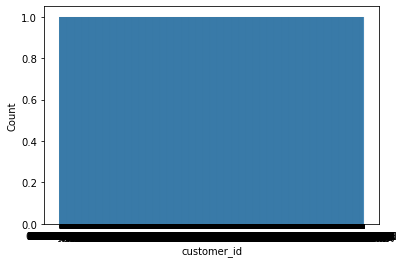

Count of variables in customer_id: 
0002-ORFBO    1
6616-AALSR    1
6625-UTXEW    1
6625-IUTTT    1
6625-FLENO    1
             ..
3352-RICWQ    1
3352-ALMCK    1
3351-NQLDI    1
3351-NGXYI    1
9995-HOTOH    1
Name: customer_id, Length: 7043, dtype: int64
--------------------


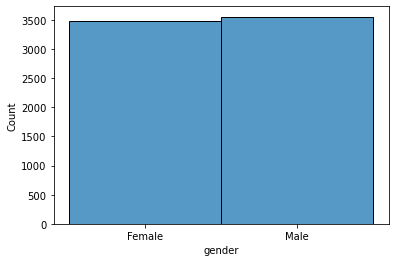

Count of variables in gender: 
Male      3555
Female    3488
Name: gender, dtype: int64
--------------------


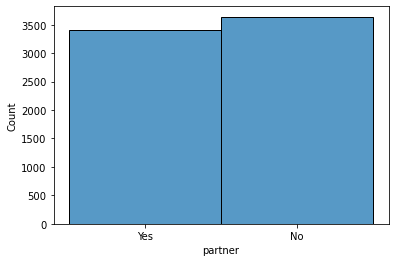

Count of variables in partner: 
No     3641
Yes    3402
Name: partner, dtype: int64
--------------------


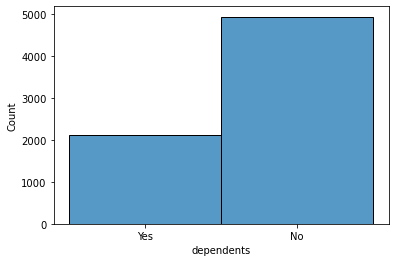

Count of variables in dependents: 
No     4933
Yes    2110
Name: dependents, dtype: int64
--------------------


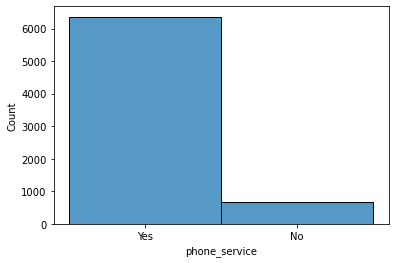

Count of variables in phone_service: 
Yes    6361
No      682
Name: phone_service, dtype: int64
--------------------


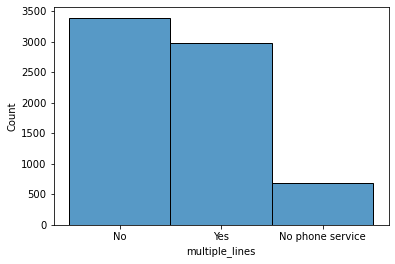

Count of variables in multiple_lines: 
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
--------------------


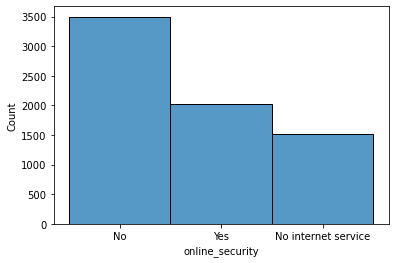

Count of variables in online_security: 
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
--------------------


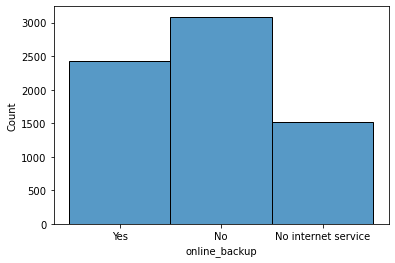

Count of variables in online_backup: 
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
--------------------


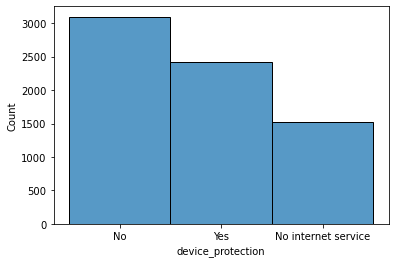

Count of variables in device_protection: 
No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64
--------------------


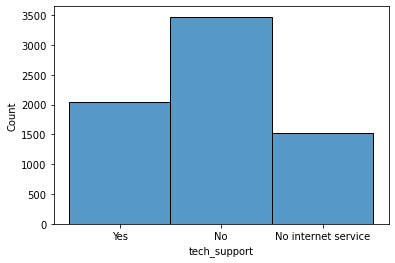

Count of variables in tech_support: 
No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64
--------------------


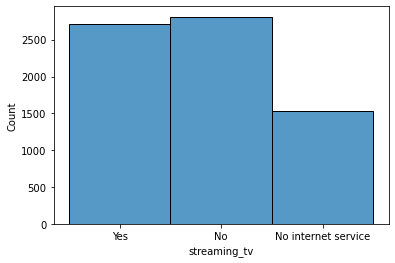

Count of variables in streaming_tv: 
No                     2810
Yes                    2707
No internet service    1526
Name: streaming_tv, dtype: int64
--------------------


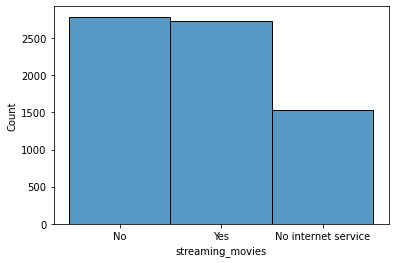

Count of variables in streaming_movies: 
No                     2785
Yes                    2732
No internet service    1526
Name: streaming_movies, dtype: int64
--------------------


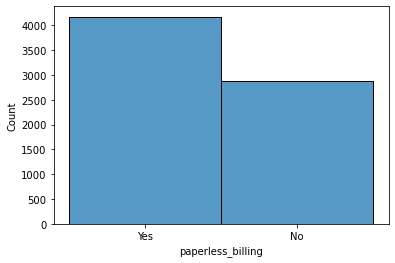

Count of variables in paperless_billing: 
Yes    4171
No     2872
Name: paperless_billing, dtype: int64
--------------------


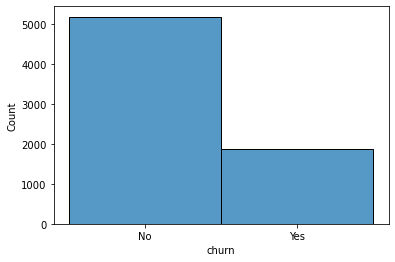

Count of variables in churn: 
No     5174
Yes    1869
Name: churn, dtype: int64
--------------------


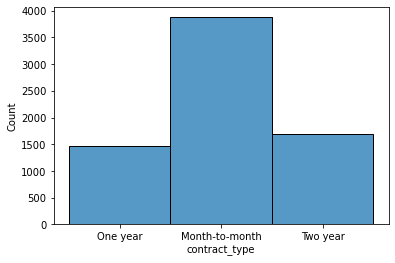

Count of variables in contract_type: 
Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64
--------------------


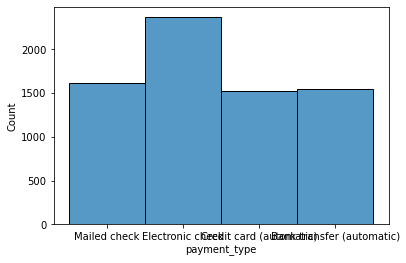

Count of variables in payment_type: 
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64
--------------------


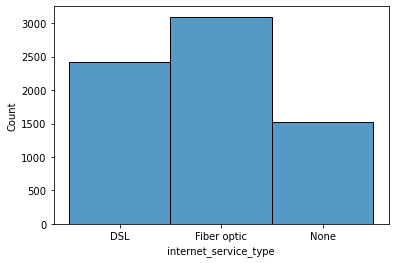

Count of variables in internet_service_type: 
Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64
--------------------


In [6]:
# Displaying histograms of all the categorical data columns.
prepare.cat_hists(df)

For several of the categorical columns displayed above there are three choices that look like:
- Yes
- No
- No phone service / No internet service

Since this information about "No phone service / No internet service" is also contained in the "phone_service" and "internet_service_type" columns, this data is redundant for any other column listing "No phone service / No internet service".

As such I will be changing all instances of "No phone service / No internet service" to No. These categorical variables will have an output of either "Yes" or "No".